## Overview

In this kernel, we compare assorted regression methods by their ability to predict residential real estate sale prices in King County, WA. 

We will begin by cleaning and transformation the data as it is prepared for the models.  Then we will use the evaluation metrics to tune each model and compare their performance.  These regression models are especially important to explore because they can offer insight into which features are most influential on sale price.  By the end of the analysis, we should be able to use the attributes of the tuned model to identify which specific characteristics of the estates most contributed to their saleprice.  

We start with an Ordinary Least Squares regression, and compare it to Ridge (L2) Regression, Lasso (L1) Regression, and ElasticNet Regression.

We will also examine a random forest model, and see which features each model prioritized by inspecting their attributes.  

The dataset is from the Kaggle challenge "House Sales in King Country, USA.  Predict house price using regression."

The data was collected between May 2014 and May 2015.

https://www.kaggle.com/harlfoxem/housesalesprediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import neighbors
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import bartlett
from scipy.stats import levene
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
raw_df = pd.read_csv('Dataset zips/housesalesprediction/kc_house_data.csv')

In [3]:
df = raw_df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

All fields have a value for each record, thare are no nulls.  

The datatypes look accurate except for date.  

### Cleaning

First let's convert all dates to datetime. 

In [5]:
df['date'] = pd.to_datetime(df['date'])

Since there are not too many features, we can use histograms to examine the distributions of each feature.  This will allow us to visually identify outliers and skewed distributions.  We can then identify where we need to transform the data. 

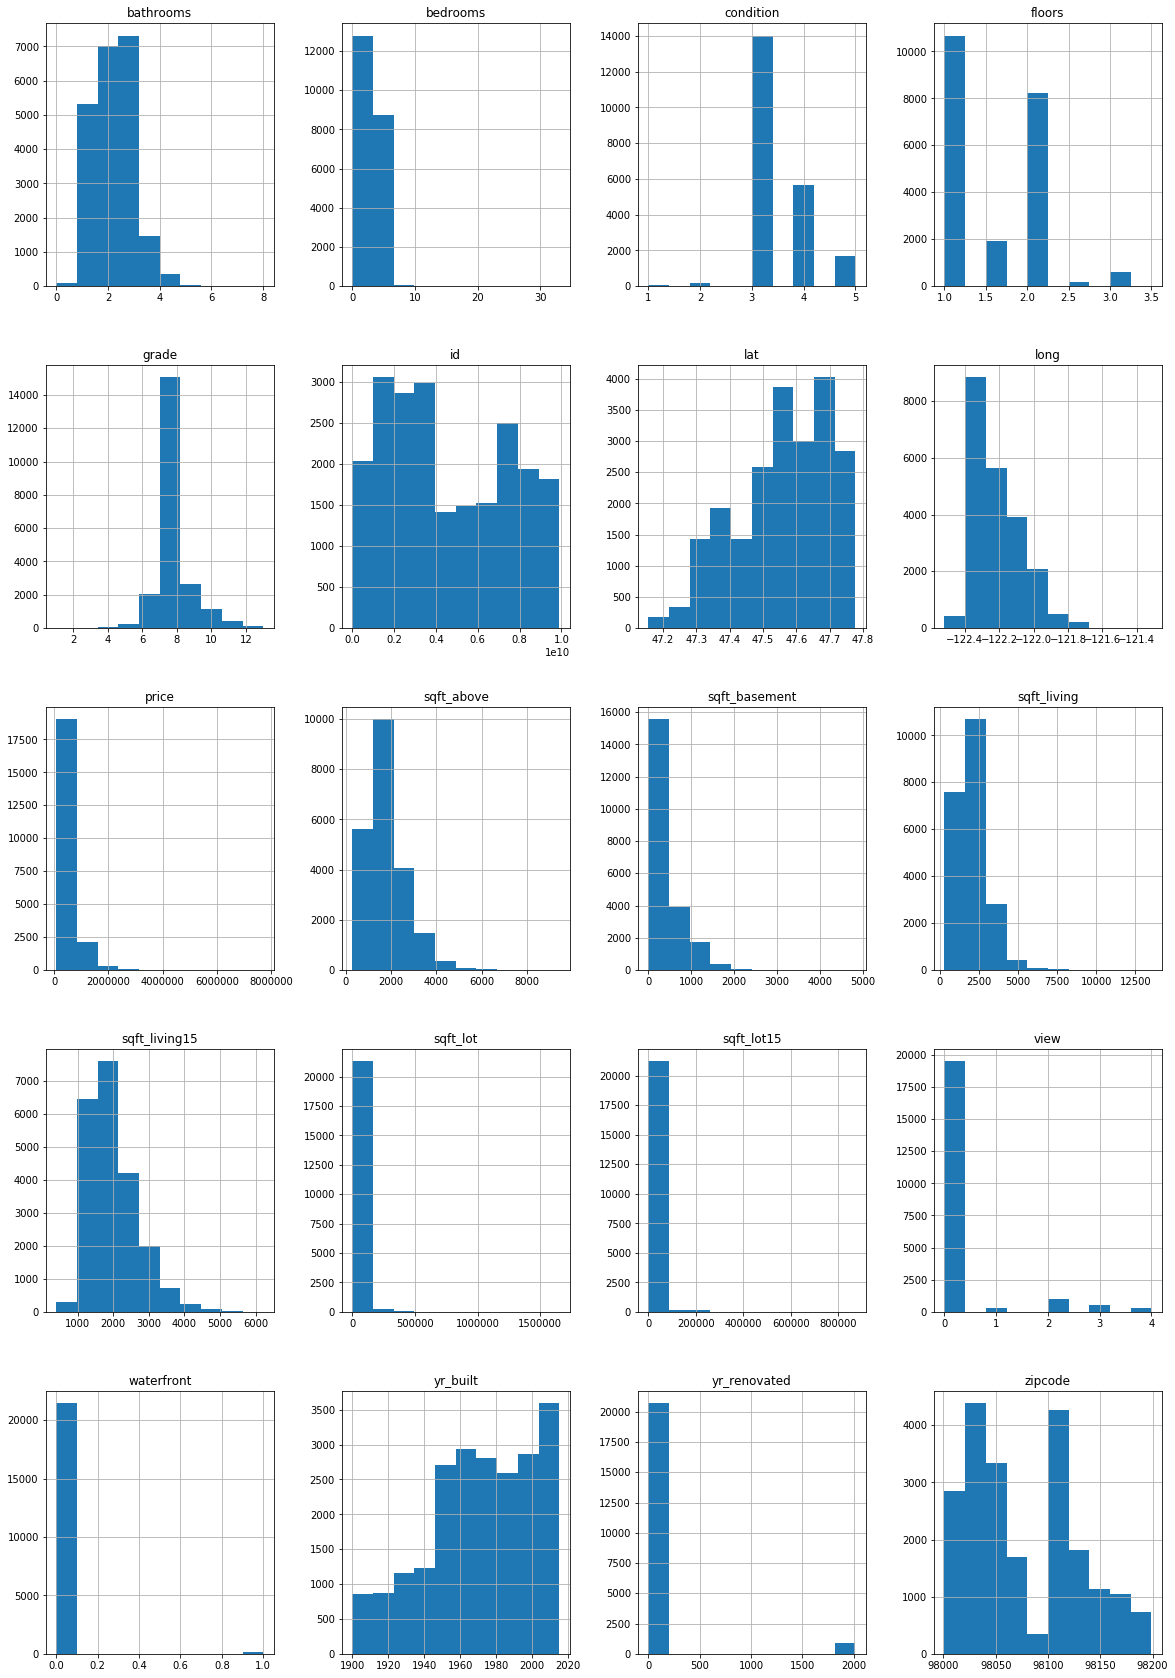

In [6]:
df.hist(figsize = (20, 30))
plt.show()

Most of the features above are continuous ratio variables.  A few are continous interval, such as yr_built, yr_renovated.

Others appear to be continuous, but are actually categorical.  These include zipcode, lat, and long.

#### Saleprice

Lets start by examining the target variable, saleprice. We will begin by creating a histogram with more bins.

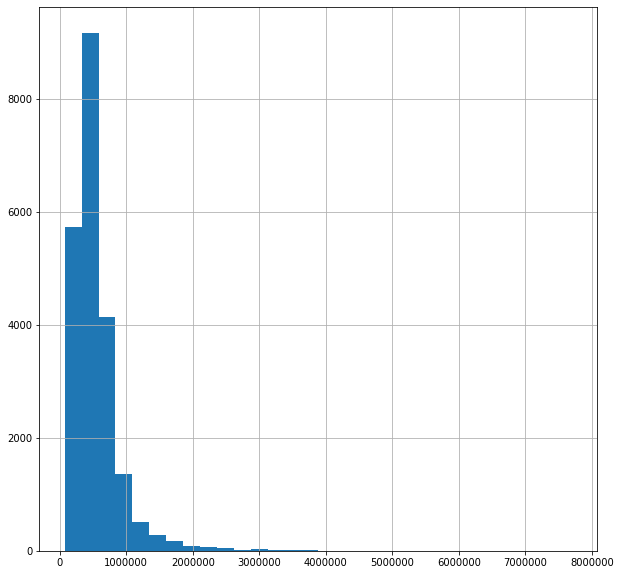

In [7]:
df['price'].hist(figsize = (10, 10), bins = 30)

The histogram does not show the oulying values for large sale price.  We can inspect a box and whisker plot instead.

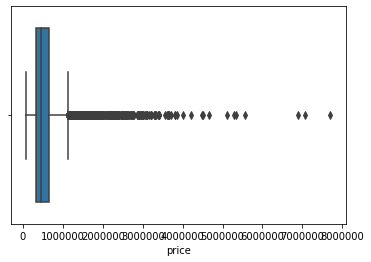

In [8]:
sns.boxplot(df['price'])

There are some obvious outlying datapoints above 6 million, lets inspect them  more closely.

In [9]:
df['price'].sort_values(ascending = False).head(10)

7252    7700000.0
3914    7062500.0
9254    6885000.0
4411    5570000.0
1448    5350000.0
1315    5300000.0
1164    5110800.0
8092    4668000.0
2626    4500000.0
8638    4489000.0
Name: price, dtype: float64

Overall, this distribution has strong kurtosis, a rightward skew. 

There are 3 records that are obvious outliers above 6 million for saleprice. These 3 records will be removed because they interfere with the boxcox transformation used below, and would be removed in any case with the outlier detection methods used later.

In [10]:
df = df[df['price'] < 6000000]

Now we will investigate some transformations to achieve a distribution that is close to the normal gaussian.

Specifically, we will compare the log transformation to the boxcox transformation.

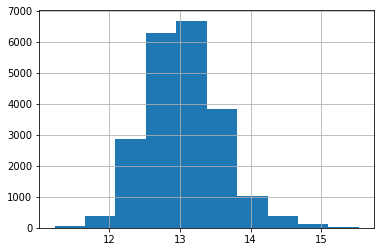

In [11]:
df['price_log'] = np.log(df['price'])
df['price_log'].hist()

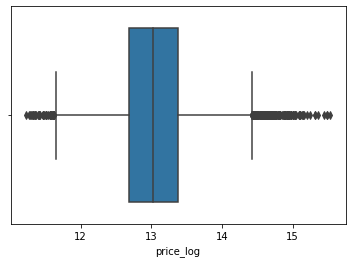

In [12]:
sns.boxplot(df['price_log'])

Let's use a QQ plot to compare the original and transformed price distribution against a normal guassian distribution.

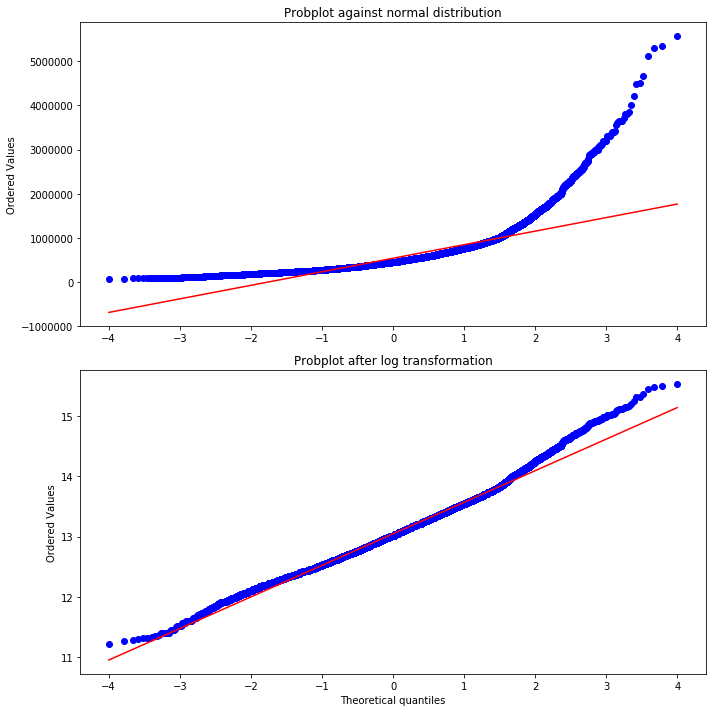

In [13]:
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(211)
prob = stats.probplot(df['price'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
                         
ax2 = fig.add_subplot(212)
prob = stats.probplot(df['price_log'], dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after log transformation')
plt.tight_layout()

The log transformation results in a distribution that is much closer to the normal distribution as evidenced by the near linear correlation.

The most egregious outliers are on the high end of price after the log transformation.  The high prices are higher than expected for a normal distribution.

Now let's see if the boxcox transformation results in a more normal distribution.

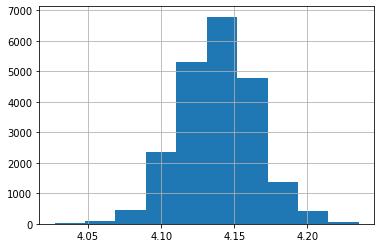

In [14]:
df['price_bxcx'] = stats.boxcox(df['price'])[0] # boxcox encounters an overflow error when prices above 6 mil are included.
df['price_bxcx'].hist()

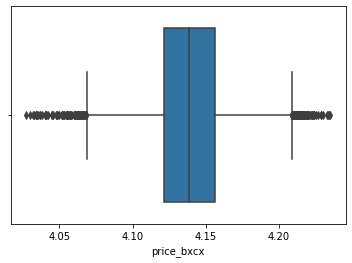

In [15]:
sns.boxplot(df['price_bxcx'])

The mean does appear to be a bit more centered.  The whiskers are slightly more symmetrical, does the qq plot confirm this?

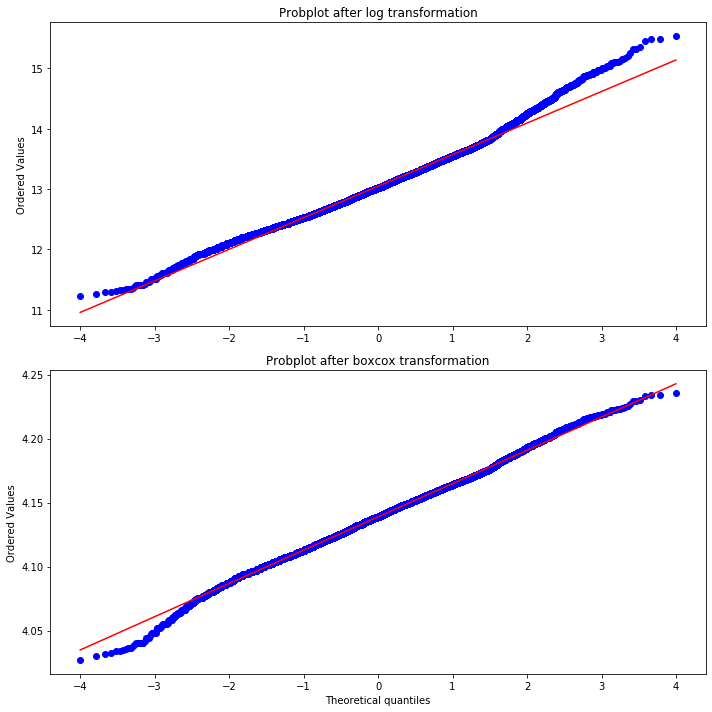

In [16]:
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(211)
prob = stats.probplot(df['price_log'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot after log transformation')
                         
ax2 = fig.add_subplot(212)
prob = stats.probplot(df['price_bxcx'], dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after boxcox transformation')
plt.tight_layout()

Yes, the boxcox transformation does seem to create the most normal distribution.  Only the low values of sale price deviate from the guassian.

Perhaps we should identify and remove more outliers in the prices.  We want to avoid removing too much data, however, since sale price is the target feature.  We want the model to be able to predict both high and low prices, not just the most common prices. 

When examining the price, we will avoid removing more than 213 records, 1% of the data.  

Let's first use interquartile range to identify outliers.

In [17]:
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.
q75, q25 = np.percentile(df['price_bxcx'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5.5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print('')
    print("The IQR threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df['price_bxcx'] > max_val) 
                      | (df['price_bxcx'] < min_val))[0]))
    ))


The IQR threshold is: 1.0
Number of outliers is: 993

The IQR threshold is: 1.5
Number of outliers is: 232

The IQR threshold is: 2.0
Number of outliers is: 40

The IQR threshold is: 2.5
Number of outliers is: 4

The IQR threshold is: 3.0
Number of outliers is: 0

The IQR threshold is: 3.5
Number of outliers is: 0

The IQR threshold is: 4.0
Number of outliers is: 0

The IQR threshold is: 4.5
Number of outliers is: 0

The IQR threshold is: 5.0
Number of outliers is: 0


A typical choice for the interquartile range threshold would be 1.5 IQRs beyond the first or third quartile.  This threshold would identify 232 outliers, and thus removes too much of the data (greater than 1%).  By increasing the threshold to 2 IQRs beyond the initial quartile, only 40 records are outliers.  Increasing the IQR threshold does not identify many or any outliers.  

Since our distribution is close to normal we don't need to use IQR to identify outliers, lets see if a method based on the mean instead of the median will be more effective.  

Now detecting outliers based on the distribution's mean and standard deviation using z-scores.

In [18]:
from scipy.stats import zscore

#The z-scores identify the number of standard deviation a record is from the mean.

z_scores = zscore(df['price_bxcx'])
for threshold in range(1,6):
    print('')
    print("The z-score threshold is: {}".format(threshold))
    #print("The indices of the outliers:")  # uncomment to add the idices of each outlying record.
    #print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(abs(z_scores) > threshold)[0]))))


The z-score threshold is: 1
Number of outliers is: 6734

The z-score threshold is: 2
Number of outliers is: 1015

The z-score threshold is: 3
Number of outliers is: 106

The z-score threshold is: 4
Number of outliers is: 7

The z-score threshold is: 5
Number of outliers is: 0


A typical choice for the z-score's threshold would be 3 sigma.  This threshold results in 106 outliers, which is still less than 1% of the data.  

Thus, for this analysis, a threshold of 3 sigma will be chosen.

Since the distribution is close to normal after the boxcox transformation, we will detect outliers use the z-score, and thus the datapoints relation to the mean.

In [19]:
df['price_bxcx_zscore'] = z_scores

We need to keep the z_scores in the dataframe, since they will change if we recalculate on the reduced dataframe.

We can then remove records with outlying price values.  We will also create df_prime, the dataset with all datapoints.

In [20]:
df_prime = df.copy() # Creating a copy of the orginal dataframe in case we need to reference it later.
df = df[abs(df['price_bxcx_zscore']) <= 3]

Now the reduced dataframe has no outlying sale prices.  Lets see how the cleaned and transformed target feature compares to its original distribution and to the normal using a prob plot.

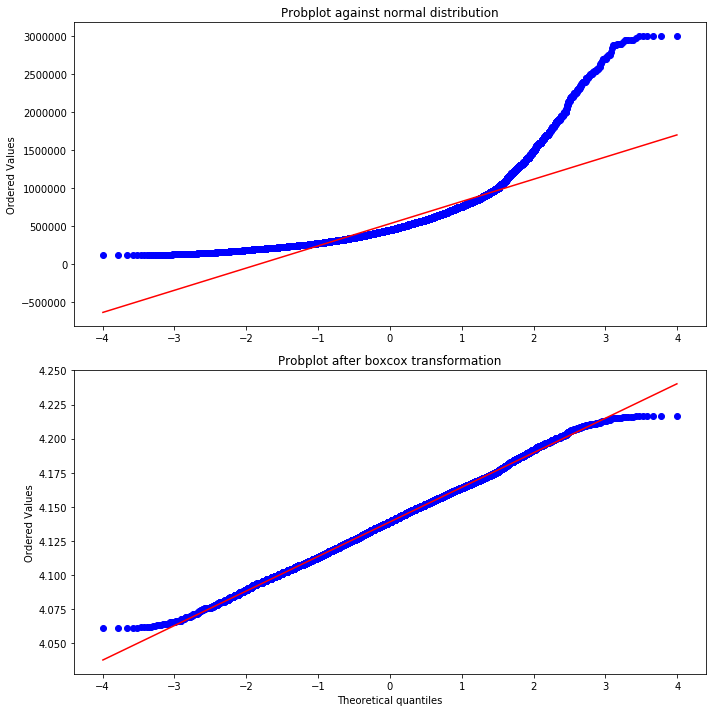

In [21]:
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(211)
prob = stats.probplot(df['price'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
                         
ax2 = fig.add_subplot(212)
prob = stats.probplot(df['price_bxcx'], dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after boxcox transformation')
plt.tight_layout()

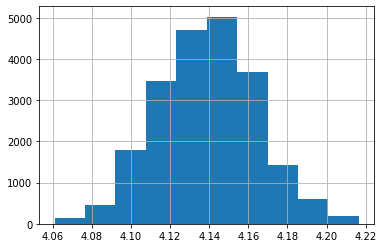

In [22]:
df['price_bxcx'].hist()

In [23]:
print('JarqueBeraResult' + str(stats.jarque_bera(df['price_bxcx'])))
print(stats.normaltest(df['price_bxcx']))

JarqueBeraResult(11.371993097744443, 0.003393150124257449)
NormaltestResult(statistic=11.590523891563787, pvalue=0.003041933500669542)


The statistical error in both cases is only 11.  On a scale that reaches into the millions, this is a small error from normal.  THe p value is below 0.05 so this is a statistically significant error even though it is small.

Now that the target feature, price, has been transformed to have a close to normal distribution, we can begin to examine the features that will be used to predict it.

### Feature Selection

Let's examine some of the features to see if they have any correlation with the target, saleprice.  

Do the saleprices chage over time? Lets examine the date of sale.  

##### Date

The data is spread out over a 1 year time frame from May 2014 to 2015.  Do any parts of the year have significantly fewer house sales? does the price change with respect to time for this short of a timeframe?

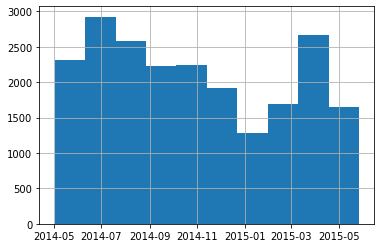

In [24]:
df['date'].hist()

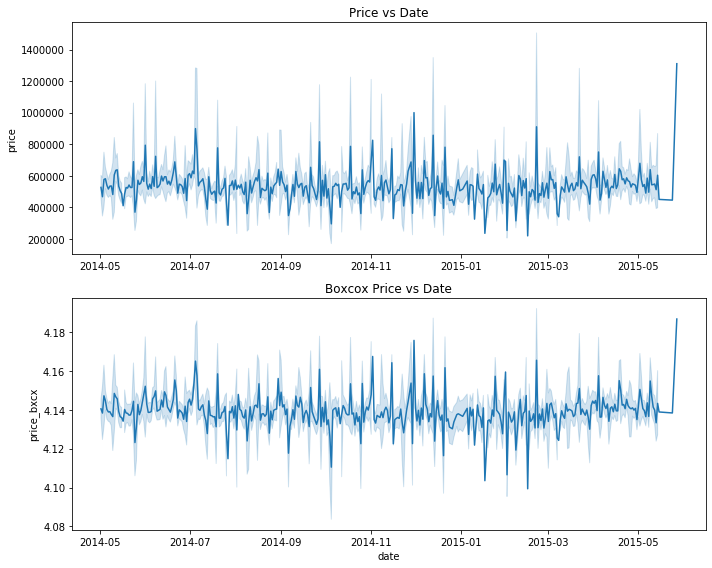

In [25]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
line = sns.lineplot(x = df['date'], y = df['price'])
ax1.set_xlabel('')
ax1.set_title('Price vs Date')

ax2 = fig.add_subplot(212)
line = sns.lineplot(x = df['date'], y = df['price_bxcx'])
ax2.set_title('Boxcox Price vs Date')
plt.tight_layout()

The date of the sale does not appear to have any correlation with the saleprice.  This is to be expected since all data is collected within a 1 year timeframe.

##### Zipcode

How about the zipcode, are saleprices significantly different in different zip codes? 

In [26]:
np.unique(df['zipcode'], return_counts = True)

(array([98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
        98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029,
        98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042,
        98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070,
        98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106,
        98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119,
        98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155,
        98166, 98168, 98177, 98178, 98188, 98198, 98199], dtype=int64),
 array([357, 196, 280, 307, 168, 496, 141, 279, 100, 195, 123, 189, 233,
        494,  81, 412, 283, 321, 256, 274, 122, 430, 542, 588,  43, 276,
        547, 221, 574, 405, 266, 406, 453, 468, 310, 118, 273, 440, 358,
        198, 350, 104, 602, 228, 331, 266, 185, 108, 267, 583, 330, 553,
        507, 183, 290, 410, 353, 494, 263, 342, 279,  56, 445, 252, 258,
        254, 260, 134, 278, 316], dtype=int64))

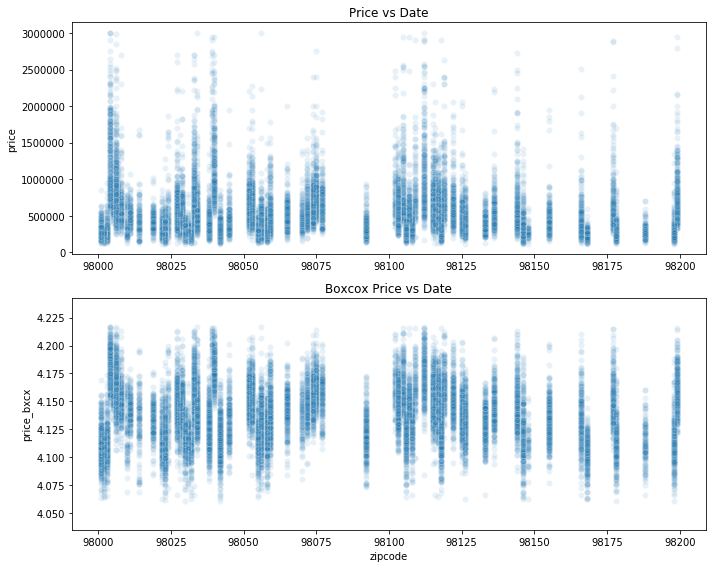

In [27]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
scatter = sns.scatterplot(x = df['zipcode'], y = df['price'], alpha = 0.1)
ax1.set_xlabel('')
ax1.set_title('Price vs Date')

ax2 = fig.add_subplot(212)
scatter = sns.scatterplot(x = df['zipcode'], y = df['price_bxcx'], alpha = 0.1)
ax2.set_title('Boxcox Price vs Date')
plt.tight_layout()

Most dates and zipcodes seem to contain a wide range of prices, thus we will not account for the date or location of the house.  These features can ba useful in predicting house prices, but are out of the scope of this analysis.  

We will create a list of the features, 'feat', that drops all fields which will not be used as features for predicting price.

In [28]:
feat = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']

Now lets examine the field in the current feature list.  When examining each individually, we will look at its distribution in relation to both the original price value, and the transformed price calculated with boxcox.

##### Waterfront

Waterfront is a boolean categorical feature that returns 1 if the lot borders an ocean, lake, or river.

How many lots actually border a water feature?  Is the price generally higher for those lots?

In [29]:
df['waterfront'][df['waterfront'] != 0].count()

143

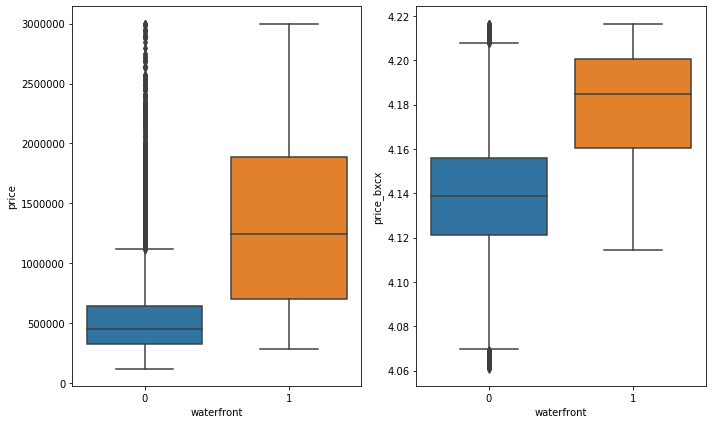

In [30]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['waterfront'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['waterfront'], y = df['price_bxcx'])

plt.tight_layout()

Only 143 records are from waterfront properties.  These records do appear to generally have a higher price.

###### View

The view from each property is graded on a scale of 0 to 4.  

In [31]:
np.unique(df['view'], return_counts = True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([19414,   330,   959,   508,   293], dtype=int64))

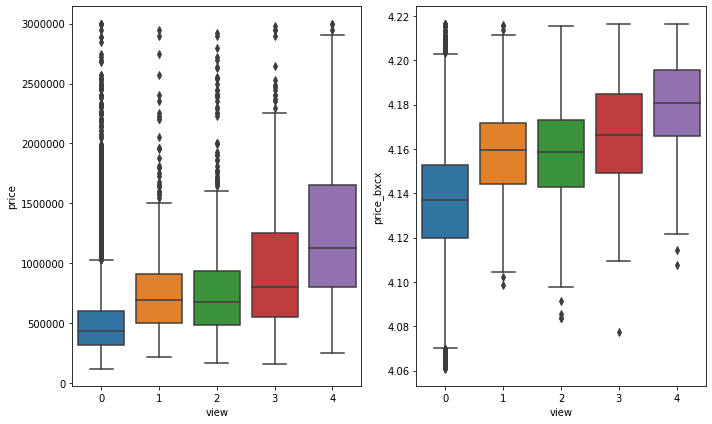

In [32]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['view'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['view'], y = df['price_bxcx'])

plt.tight_layout()

##### Condition

The condition measures how well kept the property is, where low values indicate a need for repairs and high values indicate regular maintenance.

In [33]:
np.unique(df['condition'], return_counts = True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([   27,   162, 13962,  5657,  1696], dtype=int64))

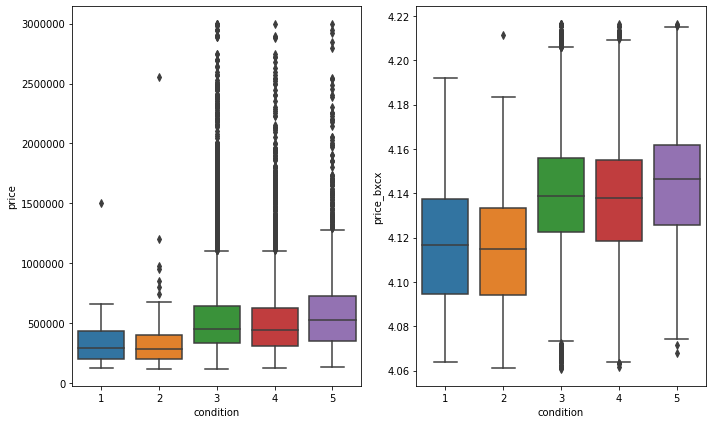

In [34]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['condition'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['condition'], y = df['price_bxcx'])

plt.tight_layout()

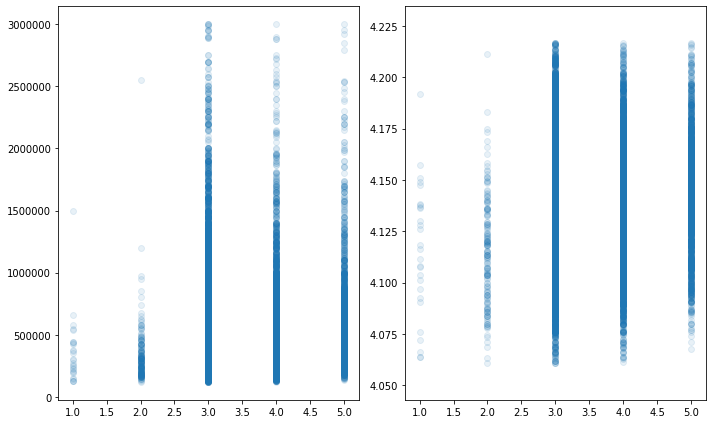

In [35]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.scatter(x = df['condition'], y = df['price'], alpha = 0.1)

plt.subplot(122)
plt.scatter(x = df['condition'], y = df['price_bxcx'], alpha = 0.1)

plt.tight_layout()

We will bucket condition into two categories, low and high, with a cutoff at 2.5.

In [36]:
df['condition'] = pd.cut(df['condition'], [0, 2.5, 5.5], labels = ['low', 'high']) # cut condition into 2 buckets

df['condition'] = pd.get_dummies(df['condition'], drop_first=True) # make condition into a boolean dummy variable, 1 is high quality

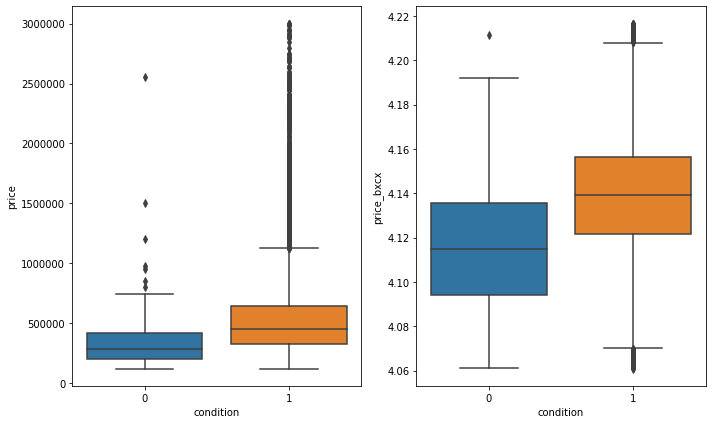

In [37]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['condition'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['condition'], y = df['price_bxcx'])

plt.tight_layout()

##### Grade

This feature represents the quality of construction and improvements, where values below 6 represent buildings that do not even meet code.  High values generally indicate custom design and architecture.

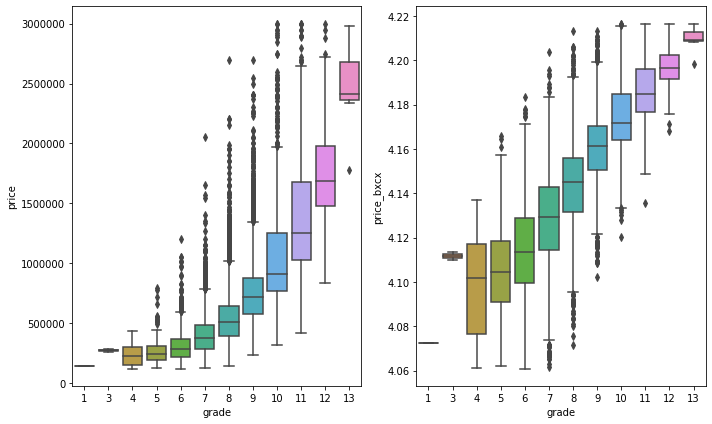

In [38]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['grade'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['grade'], y = df['price_bxcx'])

plt.tight_layout()

##### Floors

The number of stories in the house.  Decimal values of 0.5 refer to smaller spaces such as attics or lofts that do not represent an entire new floor.  

In [39]:
np.unique(df['floors'], return_counts = True)

(array([1. , 1.5, 2. , 2.5, 3. , 3.5]),
 array([10608,  1908,  8213,   156,   612,     7], dtype=int64))

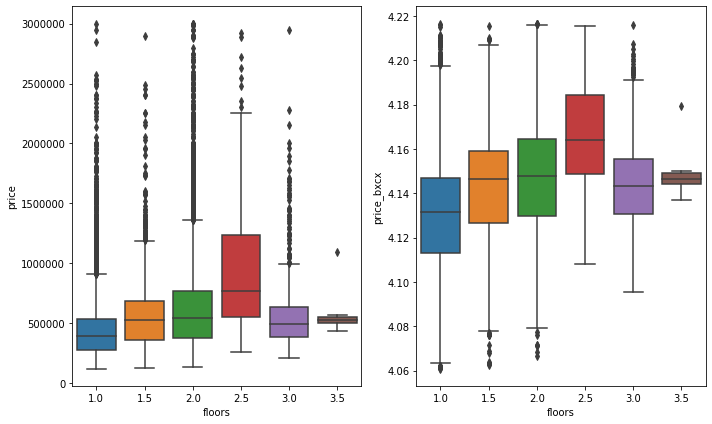

In [40]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['floors'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['floors'], y = df['price_bxcx'])

plt.tight_layout()

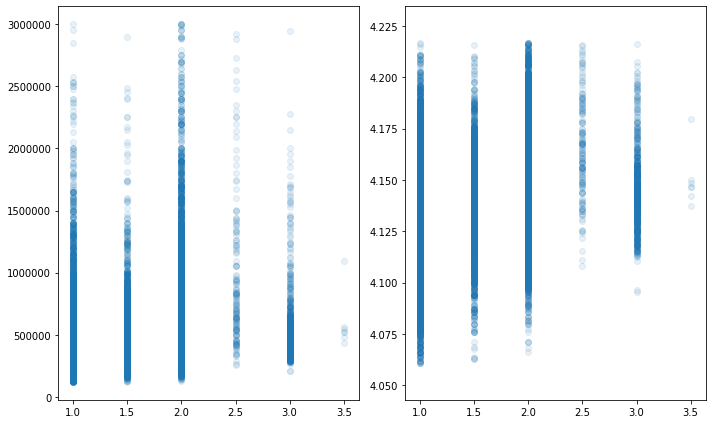

In [41]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.scatter(x = df['floors'], y = df['price'], alpha = 0.1)

plt.subplot(122)
plt.scatter(x = df['floors'], y = df['price_bxcx'], alpha = 0.1)

plt.tight_layout()

##### Bathrooms

Simply the number of bathrooms in the residence.  Decimal values such as 2.5 represent half bathrooms (those without a bath/shower).  

In [42]:
np.unique(df['bathrooms'], return_counts = True)

(array([0.  , 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
        3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ,
        5.75, 6.  , 6.25, 6.5 , 6.75, 7.5 , 8.  ]),
 array([   9,    3,   68, 3797,    9, 1445, 3046, 1929, 2047, 5379, 1185,
         750,  584,  727,  153,  133,   76,   96,   21,   17,   11,    7,
           3,    3,    1,    2,    1,    1,    1], dtype=int64))

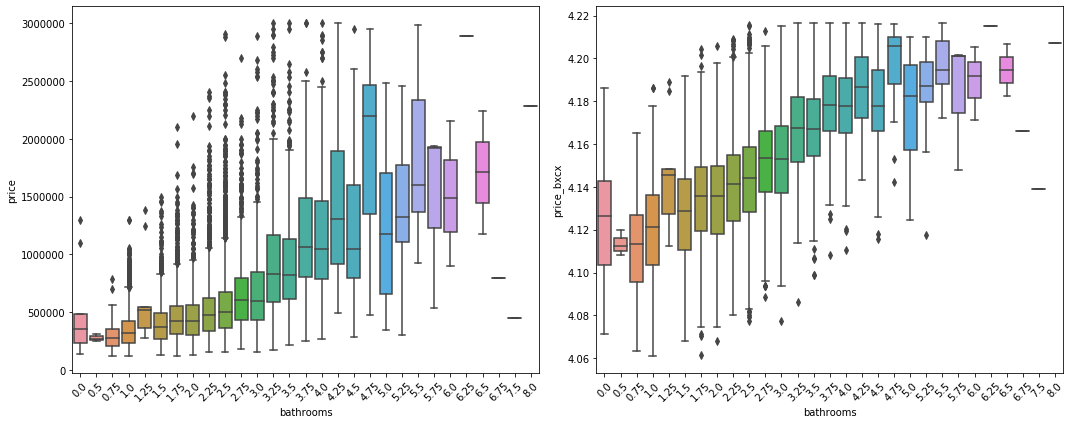

In [43]:
plt.figure(figsize = (15, 6))
plt.subplot(121).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price'])

plt.subplot(122).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price_bxcx'])

plt.tight_layout()

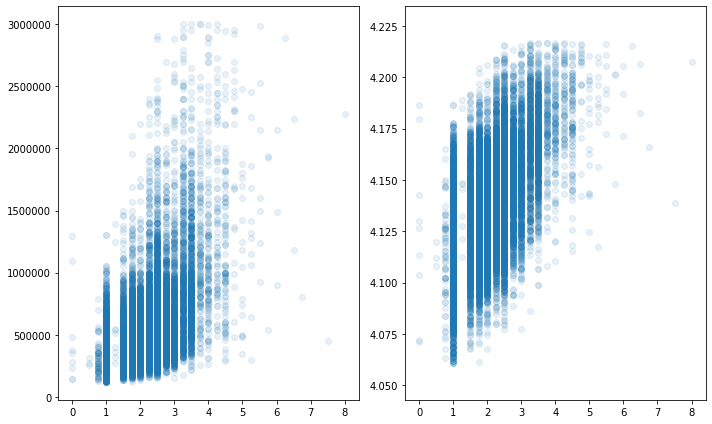

In [44]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.scatter(x = df['bathrooms'], y = df['price'], alpha = 0.1)

plt.subplot(122)
plt.scatter(x = df['bathrooms'], y = df['price_bxcx'], alpha = 0.1)

plt.tight_layout()

Some records have no bathrooms.  Now, this is theoretically a possibility if the residence used a communal space I suppose.  However, seeing as this dataset is focused on houses, this possiblity seems unlikely.  Additionally, the prices for properties with 0 bathrooms have a wide distribution and overall larger values than those with one half or full bathroom.  

In [45]:
df[feat][df['bathrooms'] == 0]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
875,0,0.0,3064,4764,3.5,0,2,1,7,3064,0,1990,0,2360,4000
3119,0,0.0,1470,979,3.0,0,2,1,8,1470,0,2006,0,1470,1399
5832,1,0.0,600,24501,1.0,0,0,0,3,600,0,1950,0,990,22549
6994,0,0.0,4810,28008,2.0,0,0,1,12,4810,0,1990,0,4740,35061
9773,0,0.0,2460,8049,2.0,0,0,1,8,2460,0,1990,0,2520,8050
9854,0,0.0,1470,4800,2.0,0,0,1,7,1470,0,1996,0,1060,7200
10481,1,0.0,690,23244,1.0,0,0,1,7,690,0,1948,0,1690,19290
14423,0,0.0,844,4269,1.0,0,0,1,7,844,0,1913,0,1380,9600
19452,0,0.0,290,20875,1.0,0,0,0,1,290,0,1963,0,1620,22850


Curiously, many of these no bathroom residences also have no bedrooms.  

In this case, we will impute the median number of bathrooms based on the number of floors for that residence.  

In [46]:
df['bathrooms'].replace(0, None, inplace = True)
df[['floors']].join(df.groupby('floors', group_keys = False).transform(lambda x: x.fillna(x.median())).astype(float))
df['bathrooms'].min()

0.5

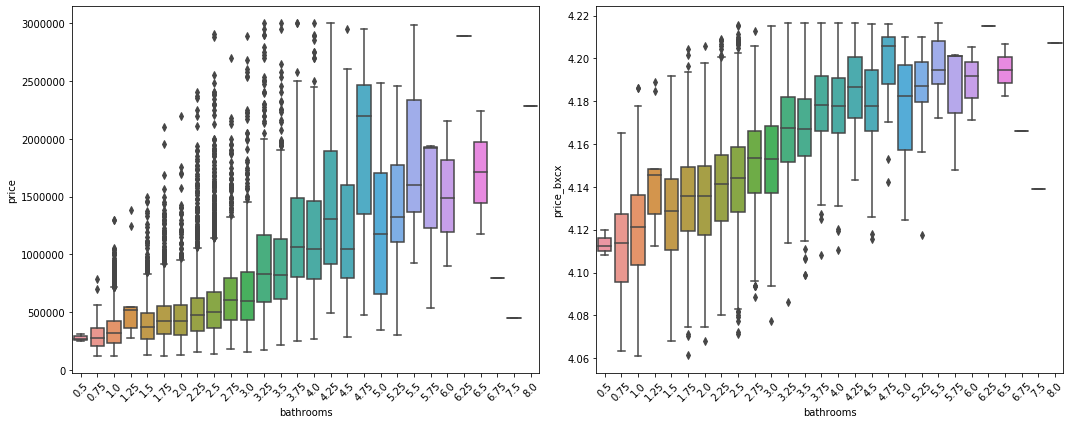

In [47]:
plt.figure(figsize = (15, 6))
plt.subplot(121).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price'])

plt.subplot(122).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price_bxcx'])

plt.tight_layout()

##### Bedrooms

The number of bedrooms in the residence.  

In [48]:
np.unique(df['bedrooms'], return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 33], dtype=int64),
 array([  13,  188, 2719, 9804, 6871, 1583,  266,   37,   12,    6,    3,
           1,    1], dtype=int64))

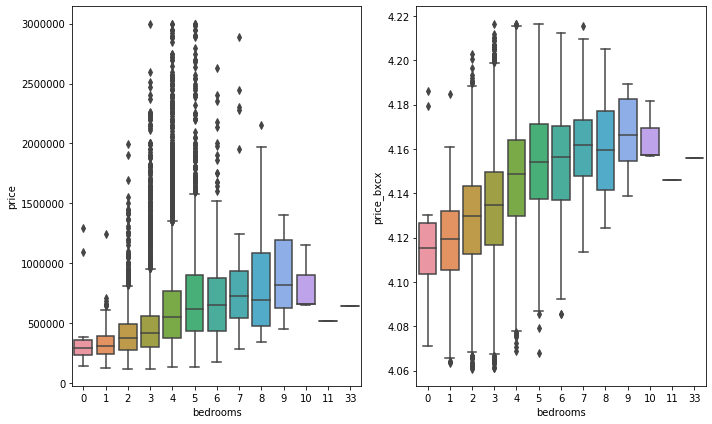

In [49]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['bedrooms'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['bedrooms'], y = df['price_bxcx'])

plt.tight_layout()

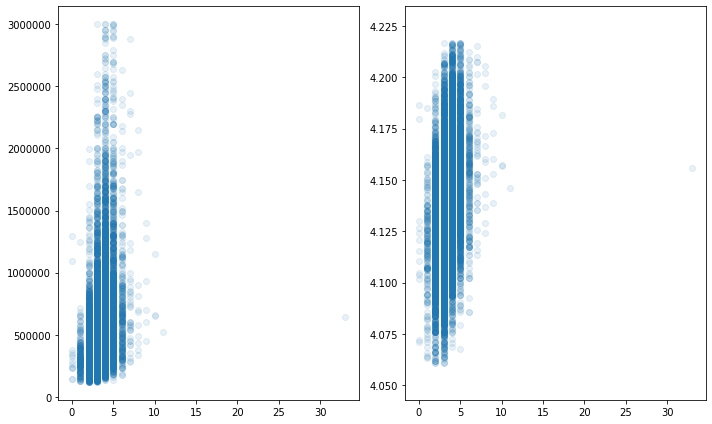

In [50]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.scatter(x = df['bedrooms'], y = df['price'], alpha = 0.1)

plt.subplot(122)
plt.scatter(x = df['bedrooms'], y = df['price_bxcx'], alpha = 0.1)

plt.tight_layout()

One record has 33 bedrooms.  This seems outlandish and is assumed to be an error.  

In [51]:
df[feat][df['bedrooms'] == 33]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
15870,33,1.75,1620,6000,1.0,0,0,1,7,1040,580,1947,0,1330,4700


In [52]:
df['price'][df['bedrooms'] == 33]

15870    640000.0
Name: price, dtype: float64

The lot that allegedly has 33 bedrooms only has 1.75 bathrooms, 1,620 square footage,and a price of 64,000.

It seems much more likely the value was entered incorrectly, it will be replaced with 3.

In [53]:
df['bedrooms'][df['bedrooms'] == 33] = 3

Much like the bathrooms, some records have no bedrooms.  These properties could be studio style and thus not count the main room as a true bedroom.  Notably, the properties with 0 bedrooms also have the lowest price.  Let's take a cursory glance ar these entries to see if they make any sense.

In [54]:
df[feat][df['bedrooms'] == 0]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
875,0,2.25,3064,4764,3.5,0,2,1,7,3064,0,1990,0,2360,4000
3119,0,1.00,1470,979,3.0,0,2,1,8,1470,0,2006,0,1470,1399
3467,0,1.50,1430,1650,3.0,0,0,1,7,1430,0,1999,0,1430,1650
4868,0,1.00,390,5900,1.0,0,0,0,4,390,0,1953,0,2170,6000
6994,0,2.50,4810,28008,2.0,0,0,1,12,4810,0,1990,0,4740,35061
8477,0,2.50,2290,8319,2.0,0,0,1,8,2290,0,1985,0,2500,8751
8484,0,2.50,1810,5669,2.0,0,0,1,7,1810,0,2003,0,1810,5685
9773,0,2.50,2460,8049,2.0,0,0,1,8,2460,0,1990,0,2520,8050
9854,0,2.00,1470,4800,2.0,0,0,1,7,1470,0,1996,0,1060,7200
12653,0,2.50,1490,7111,2.0,0,0,1,7,1490,0,1999,0,1500,4675


Many of these records have multiple floors, which seems unusual for a residence with no bedrooms.  Thus, we will use the same strategy of imputing the median  number of bedrooms for that number of floors.

In [55]:
df['bedrooms'].replace(0, None, inplace = True)
df[['floors']].join(df.groupby('floors', group_keys = False).transform(lambda x: x.fillna(x.median())).astype(float))
df['bedrooms'].min()

1

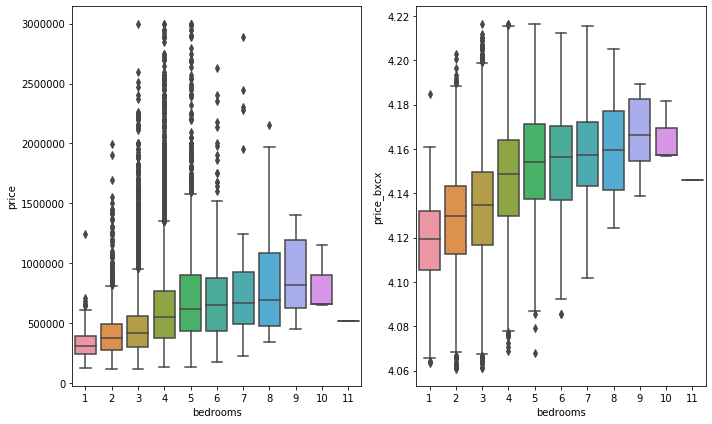

In [56]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
sns.boxplot(x = df['bedrooms'], y = df['price'])

plt.subplot(122)
sns.boxplot(x = df['bedrooms'], y = df['price_bxcx'])

plt.tight_layout()

Now that these features have been cleaned and error corrected, we can move forward with examining their predictive power. 

##### Correlation

So far we have only examined the features with respect to our target, price.  With a correlation matrix, we can inspect their correlations with each other. 

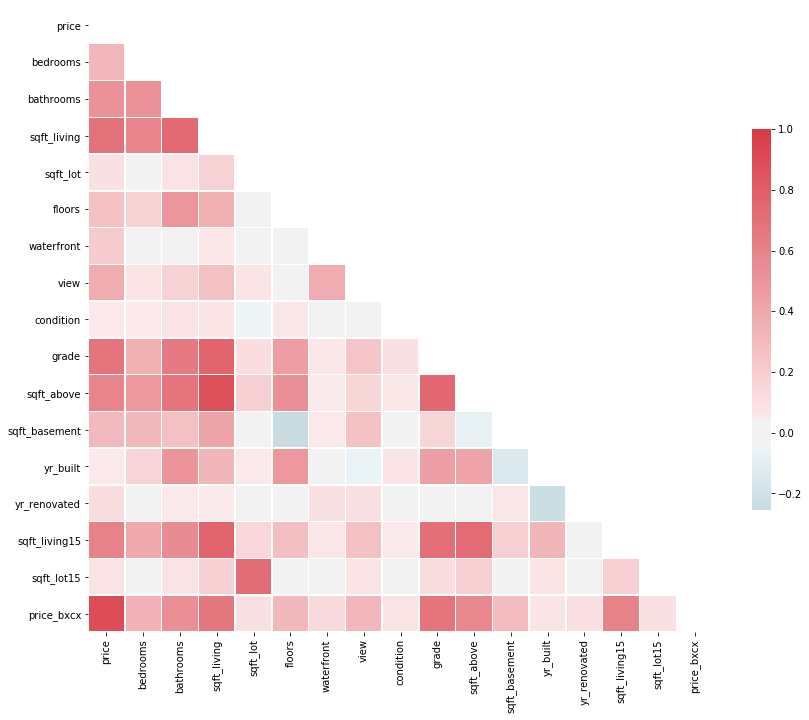

In [57]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'price_log', 'price_bxcx_zscore'], axis = 1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(14,14))
sns.heatmap(df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'price_log', 'price_bxcx_zscore'], axis = 1).corr(), mask=mask, cmap= cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#adapted code from kirgsn

The features most correlated with price are: sqft_living, sqft_above, grade, sqft_living15, lowest are yr_built, yr_renovated, condition, and sqft_lot15.

price and price_bxcx are obviously correlated because one is a transformation of the other.

Some feature that are highly correlated together are:
grade with sqft_above and sqft_living
sqft_living with sqft_above (as expected)
sqft_living and sqft_lot with sqft_living15 and sqft_lot15
bathrooms with sqft_living and sqft_above

We will leave these features as is, but must keep in mind the cross correlation.

We will begin by closely examining the most correlated feature, sqft_living.

<Figure size 576x576 with 0 Axes>

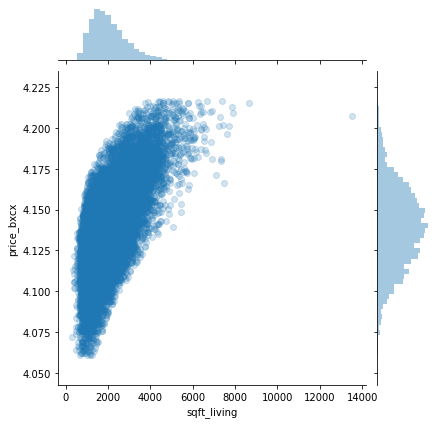

In [58]:
plt.figure(figsize = (8, 8))
sns.jointplot(df['sqft_living'], df['price_bxcx'], alpha = 0.2)
plt.show()

It appears that a linear model would fit well, lets create one to use as a baseline comparison for future models.  

### Modeling

Lets create some regression models to predict houseprice.

#### Simple Linear Regression

To start we use a single feature, living area square footage (sqft_living), to predict the target, price.  This will represent a simple one dimensional approach with minimal transformation of the data to be used as a baseline.

We will create train and test sets, then use Ordinary Least Squares on the train data to fit the model and comapre its predictions to the test set.

In [59]:
Y = np.array(df['price'])

X = np.array(df['sqft_living']).reshape(-1, 1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 17203
The number of observations in test set is 4301


In [61]:
#Adding constants to the feature train and test sets.
X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X_train_cons, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

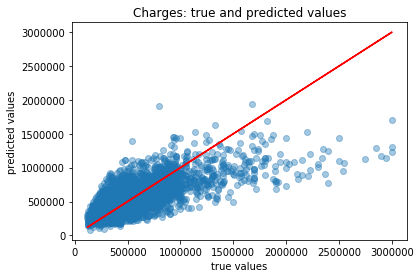

R-squared of the training set: 0.47550968315424036
-----Test set statistics-----
R-squared of the test set: 0.47927689095081816
Mean absolute error of the prediction is: 166173.2674542523
Mean squared error of the prediction is: 57325765542.480835
Root mean squared error of the prediction is: 239427.99657199832
Mean absolute percentage error of the prediction is: 34.7204826486384


In [62]:
# We are making predictions here
y_preds = lrm.predict(X_test_cons)

plt.scatter(y_test, y_preds, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lrm.score(X_train_cons, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lrm.score(X_test_cons, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

R-squared is only around 0.5, and mean absolute percentage of error is 35%.  The plot above shows that some of the true values are much larger than the predicted value.  Anything under the red line was underpredicted, and over the red line was overpredicted.  This model has a tendency to underpredict for large sale price.  

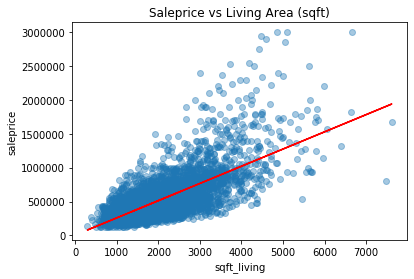

In [63]:
plt.scatter(X_test, y_test, alpha = 0.4)
plt.plot(X_test, y_preds, color="red")
plt.xlabel('sqft_living')
plt.ylabel('saleprice')
plt.title('Saleprice vs Living Area (sqft)')
plt.show()

Here we can see that there are some very large saleprices even for lower values of living area square footage, futher evidence that this model underpredicts many larger prices.

#### Multiple Regression

Now we will create some multi dimensional regression models.  We will again start with Ordinary Least Squares, but this time with all the features included.  We will then compare this to the various regularization techniques, Lasso (L1), Ridge(L2), and ElasticNet regression.  

In [64]:
Y = df['price_bxcx']

X = df[feat]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 17203
The number of observations in test set is 4301


In [66]:
#Adding constants to the feature train and test sets.
X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

#### Ordinary Least Squares

In [67]:
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X_train_cons, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
lrm.score(X_train_cons, y_train)

0.6159623672757693

In [69]:
results = sm.OLS(y_train, X_train_cons).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_bxcx   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1969.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        16:48:41   Log-Likelihood:                 47083.
No. Observations:               17203   AIC:                        -9.414e+04
Df Residuals:                   17188   BIC:                        -9.402e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.5831      0.011    436.351      0.000       4.562       4.604
bedrooms         -0.0012      0.000     -7.135      0.000      -0.002      -0.001
bathrooms         0.0042      0.000     14.853      0.000       0.004       0.005
sqft_living    4.405e-06   2.04e-07     21.550      0.000       4e-06    4.81e-06
sqft_lot       1.319e-08   4.32e-09      3.052      0.002    4.72e-09    2.17e-08
floors            0.0062      0.000     20.188      0.000       0.006       0.007
waterfront        0.0153      0.002      9.679      0.000       0.012       0.018
view              0.0015      0.000      7.997      0.000       0.001       0.002
condition         0.0089      0.001      6.871      0.000       0.006       0.011
grade             0.0099      0.000     53.655      0.000       0.010       0.010
sqft_above    -4.113e-07   1.94e-07     -2.125      0.034   -7.91e-07    -3.2e-08
sqft_basement  4.816e-06    2.3e-07     20.950      0.000    4.37e-06    5.27e-06
yr_built         -0.0003    5.5e-06    -52.072      0.000      -0.000      -0.000
yr_renovated   1.439e-07   3.15e-07      0.457      0.648   -4.73e-07    7.61e-07
sqft_living15  5.969e-06   2.95e-07     20.251      0.000    5.39e-06    6.55e-06
sqft_lot15    -2.205e-08   6.48e-09     -3.404      0.001   -3.47e-08   -9.35e-09
==============================================================================
Omnibus:                      271.113   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.289
Skew:                          -0.297   Prob(JB):                     4.13e-63
Kurtosis:                       3.218   Cond. No.                     2.72e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.8e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Looking at the coefficient for each feature and its corresponding p-value, we can see that the only features that has a p-value above 0.05 are sqft_above and yr_renovated.  The high p-value suggests that there is a statistically significant chance these features have a coefficient equal to 0 and thus no affect on the target. 

The p-value for each feature tests the null hypothesis that the coefficient is equal to zero (no effect). A value below 0.05 indicates that you can reject the null hypothesis. Thus, a predictor with a low p-value is likely to be meaningful because changes in the predictor's value are related to changes in the response variable.

The feature sqft_above is also highly correlated with sqft_living as shown in the heatmap earlier.

With this in mind, sqft_above and yr_renovated are strong candidates for dropping from the feature list.  

It should also be noted that the coefficient represents the change in price for a 1 unit change in the features value.  Thus a boolean feature such as waterfront will naturally have a higher coefficient than a continuous one like sqft_living.  To represent this, we will multiply each feature's coefficient by its total range of values.  

In [70]:
coefficients = list(zip(feat, lrm.coef_))
feat_coef = pd.DataFrame(data = coefficients, columns = ['feature', 'coefficient'])

In [71]:
feat_coef['coef_by_range'] = range(0, feat_coef.shape[0])
for feature in feat:
    feat_coef['coef_by_range'][feat_coef['feature'] == feature] = feat_coef['coefficient'][feat_coef['feature'] == feature] * (df[feature].max() - df[feature].min())

In [72]:
feat_coef.sort_values(by = 'coef_by_range', ascending = False)

,feature,coefficient,coef_by_range
9,sqft_above,9.885590e-03,9.015658e+01
2,sqft_living,4.249092e-03,5.630047e+01
3,sqft_lot,4.404734e-06,7.271507e+00
14,sqft_lot15,5.968962e-06,5.196274e+00
8,grade,8.934374e-03,1.072125e-01
6,view,1.532456e-02,6.129825e-02
5,waterfront,6.207788e-03,6.207788e-03
7,condition,1.488330e-03,1.488330e-03
13,sqft_living15,1.438738e-07,8.360508e-04
11,yr_built,4.816075e-06,5.538487e-04


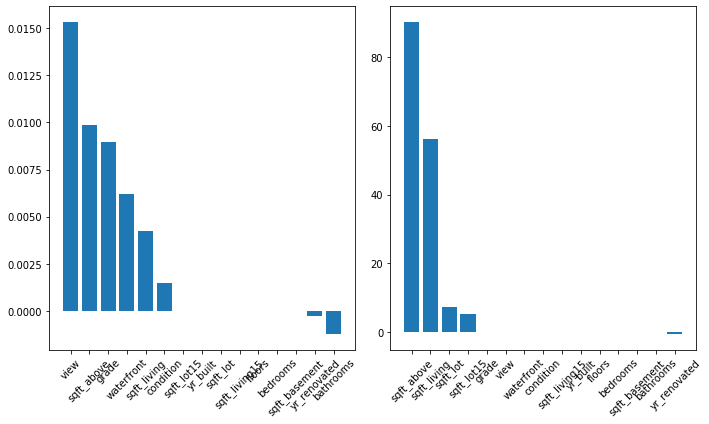

In [73]:
plt.figure(figsize = (10, 6))
plt.subplot(121).tick_params(axis = 'x', rotation = 45)
plt.bar(feat_coef.sort_values(by = 'coefficient', ascending = False)['feature'], feat_coef.sort_values(by = 'coefficient', ascending = False)['coefficient'])

plt.subplot(122).tick_params(axis = 'x', rotation = 45)
plt.bar(feat_coef.sort_values(by = 'coef_by_range', ascending = False)['feature'], feat_coef.sort_values(by = 'coef_by_range', ascending = False)['coef_by_range'])

plt.tight_layout()


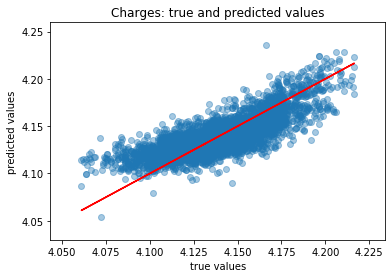

R-squared of the training set: 0.6159623672757693
-----Test set statistics-----
R-squared of the test set: 0.613561116335936
Mean absolute error of the prediction is: 0.012716352775384552
Mean squared error of the prediction is: 0.00025261933571643945
Root mean squared error of the prediction is: 0.015894003136920524
Mean absolute percentage error of the prediction is: 0.30741517807014435


In [74]:
# We are making predictions here
y_preds = results.predict(X_test_cons)

plt.scatter(y_test, y_preds, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lrm.score(X_train_cons, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lrm.score(X_test_cons, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

#### Ridge Regression (L2)

In [75]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha = 10**3)
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

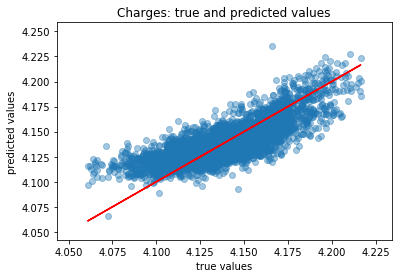

R-squared of the training set: 0.611895687022207
-----Test set statistics-----
R-squared of the test set: 0.6103568845106604
Mean absolute error of the prediction: 0.012760826865348065
Mean squared error of the prediction: 0.0002547139771963216
Root mean squared error of the prediction: 0.01595976118857427
Mean absolute percentage error of the prediction: 0.3085111515204782


In [76]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [77]:
ridge_results = zip(X.columns, ridgeregr.coef_)

In [78]:
ridge_results

In [79]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [80]:
ridgeregr.coef_

array([-1.22315386e-03,  3.62245339e-03,  5.07323861e-06,  1.05154146e-08,
        4.97841617e-03,  1.41936522e-03,  2.01387713e-03,  1.17910271e-03,
        8.93314341e-03,  3.88432342e-07,  4.68480635e-06, -2.64940335e-04,
        6.63835583e-07,  6.15959451e-06, -2.49280547e-08])

In [81]:
ridgeregr.intercept_

4.55536354087907

#### Lasso Regression (L1)

In [82]:
lassoregr = Lasso(alpha=10**6) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)


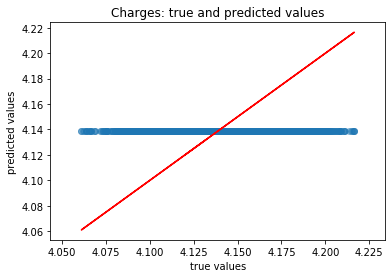

R-squared of the training set: 0.0
-----Test set statistics-----
R-squared of the test set: -0.00035814515112564393
Mean absolute error of the prediction: 0.020465291491109903
Mean squared error of the prediction: 0.0006539450888338606
Root mean squared error of the prediction: 0.02557235008429731
Mean absolute percentage error of the prediction: 0.4944058284779537


In [83]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

#### Elastinet Regression (L1 + L2)

In [84]:
elasticregr = ElasticNet(alpha=10**6, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

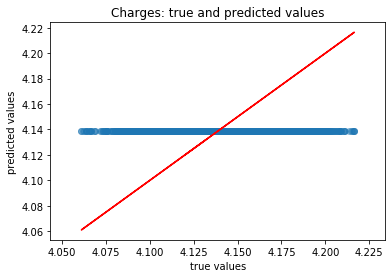

R-squared of the training set: 0.0
-----Test set statistics-----
R-squared of the test set: -0.00035814515112564393
Mean absolute error of the prediction: 0.020465291491109903
Mean squared error of the prediction: 0.0006539450888338606
Root mean squared error of the prediction: 0.02557235008429731
Mean absolute percentage error of the prediction: 0.4944058284779537


In [85]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [86]:
stop

NameError: name 'stop' is not defined

In [ ]:
Y = df['price_bxcx']

X = df[feat]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

In [ ]:
#Adding constants to the feature train and test sets.
X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

#### Ordinary Least Squares

In [ ]:
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X_train_cons, y_train)

In [ ]:
results = sm.OLS(y_train, X_train_cons).fit()

results.summary()

In [ ]:
# We are making predictions here
y_preds = results.predict(X_test_cons)

plt.scatter(y_test, y_preds, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lrm.score(X_train_cons, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lrm.score(X_test_cons, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

#### Ridge Regression (L2)

In [ ]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha = 10**-20)
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

In [ ]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
from sklearn.linear_model import RidgeCV

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeCVregr = RidgeCV(alphas = np.logspace(start = -5, stop = 6))
ridgeCVregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeCVregr.predict(X_train)
y_preds_test = ridgeCVregr.predict(X_test)

In [ ]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(ridgeCVregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(ridgeCVregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
ridgeCVregr.alpha_

#### Lasso Regression (L1)

In [ ]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**-1) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)


In [ ]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:

lassoCVregr = LassoCV()
lassoCVregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoCVregr.predict(X_train)
y_preds_test = lassoCVregr.predict(X_test)

In [ ]:
lassoCVregr.alpha_

In [ ]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
lasoo_results = zip(X.columns, lassoregr.coef_)

In [ ]:
lassoregr.coef_

In [ ]:
X.columns

In [ ]:
ridgeregr.coef_

In [ ]:
lassoregr.intercept_

#### Elastinet Regression (L1 + L2)

In [ ]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**-5, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

In [ ]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
from sklearn.linear_model import ElasticNetCV

elasticCVregr = ElasticNetCV(l1_ratio=0.5) 
elasticCVregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticCVregr.predict(X_train)
y_preds_test = elasticCVregr.predict(X_test)

In [ ]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(elasticCVregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(elasticCVregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [ ]:
elasticCVregr.alpha_

In [ ]:
stop

#### Random Forest

In [ ]:
rfr = ensemble.RandomForestRegressor()

cross_val_score(rfr, X, Y, cv=5)

Overfit

sklearn.feature_selection.RFE

In [ ]:
stop

#### SVM

In [ ]:
svr = SVR()
svr.fit(X, Y)

In [ ]:
plt.scatter(Y, svr.predict(X))

In [ ]:
svr.score(X, Y)

In [ ]:
cross_val_score(svr, X, Y, cv=5)

In [ ]:
stop

#### KNN

In [ ]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=1)
X_pca_ar = pca.fit_transform(X_std)



In [ ]:
X_pca_ar

In [ ]:
X_pca = pd.DataFrame(X_pca_ar)

In [ ]:
X_pca[0]

In [ ]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_w.fit(X_pca[0], Y)

# Set up our prediction line.
T = np.arange(0, 400, 1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=3, Unweighted')
plt.show()

### Appendix

In [ ]:
df_test = raw_df.copy()
df_test['price_bxcx'] = stats.boxcox(df_test['price'])[0]
df_test['price_bxcx'].unique()

the boxcox gives all the same value, this bug is noted in the link.  Has to do with the lambda value that is used in calculating the boxcox giving results below machine epilon.
"x**lambda all become less than the machine epsilon,"

https://github.com/scipy/scipy/issues/6873

Handling outliers.  Drop? Winsorize?



from scipy.stats.mstats import winsorize

# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
winsorized_prices = winsorize(df['price'], (0, 0.10))

winsorized_prices

winsorized_prices[0].max()

df = df[df['price'] < 6000000]

#### Feature descriptions

sqft_living15, the average house square footage of the 15 closest houses

sqft_lot15, the average lot square footage of the 15 closest houses

UILDING GRADE
    	Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

BUILDING CONDITION
    	Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.